In [1]:
x=1

1

In [2]:
typeof(x)

Int64

In [3]:
f(x)=2x

f (generic function with 1 method)

In [4]:
f(2)

4

In [5]:
function g(x, y)
    z= x+y
    return z^2
end
      

g (generic function with 1 method)

In [6]:
g(2,2)

16

In [8]:
s=0
for i in 1:10
    s=s+1
end


In [9]:
s

10

In [11]:
typeof(1:10)

UnitRange{Int64}

In [12]:
using Bloqade


In [13]:
triangular = GeneralLattice([(1.0, 0.0), (0.5, 0.5*sqrt(3))], [(0.0, 0.0)])
GeneralLattice{2, 1, Float64}(((1.0, 0.0), (0.5, 0.8660254037844386)), ((0.0, 0.0),))

GeneralLattice{2, 1, Float64}(((1.0, 0.0), (0.5, 0.8660254037844386)), ((0.0, 0.0),))

In [14]:
chain = ChainLattice()

ChainLattice()

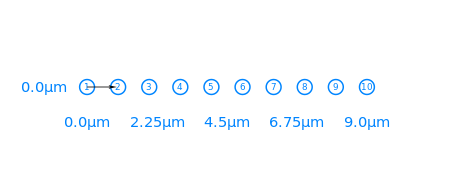

In [15]:
BloqadeLattices.DEFAULT_LINE_COLOR[] = "#0085FF"

unitvectors(lattice::AbstractLattice{2}, scale=0.9) = [((0.0, 0.0), v .* scale) for v in lattice_vectors(lattice)]
Bloqade.plot(generate_sites(chain, 10); vectors=[((0.0, 0.0), (0.9, 0.0))], bond_linewidth=0.015)

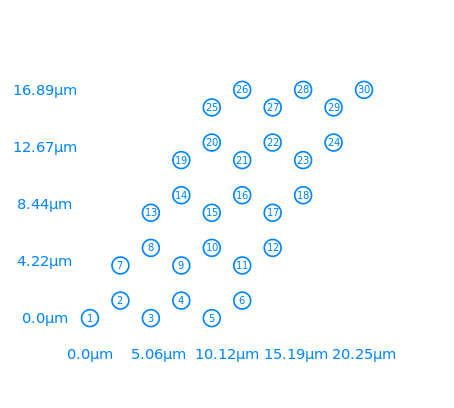

In [16]:
atoms = generate_sites(HoneycombLattice(), 3, 5; scale = 4.5)

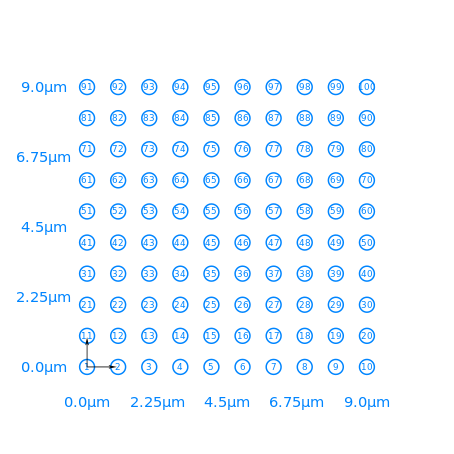

In [17]:
square = SquareLattice()
Bloqade.plot(generate_sites(square, 10, 10); vectors=unitvectors(square), bond_linewidth=0.015)

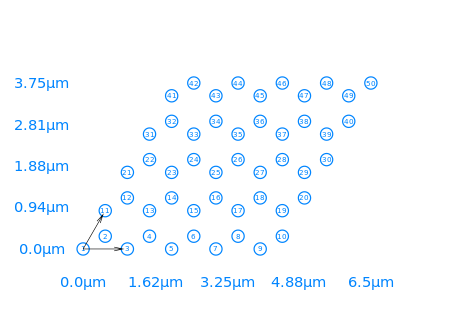

In [18]:
honeycomb = HoneycombLattice()
Bloqade.plot(generate_sites(honeycomb, 5, 5); vectors=unitvectors(honeycomb), bond_linewidth=0.015)